# Overview

This is the first part of a 2 part tutorial which runs the PaRoutes benchmark.
In this half of the tutorial, we run search algorithms using a pre-trained reaction model.
Because these algorithms require policies and value functions,
these must be carefully chosen before running the algorithm.

**NOTE:** the PaRoutes reaction model requires the following additional packages:
- `pandas` (to load data table)
- `rdchiral` (to apply reaction templates)
- `keras` (their pre-trained model is a template-classification model using keras)

The model also requires some data files, which can be downloaded with `paroutes_setup.sh`.Running the following commands should set up everything:

```
pip install -U tensorflow keras
conda install -c conda-forge rdchiral_cpp  # faster C++ version
conda install -c conda-forge pandas
cd tutorials/search  # need to be in this directory for the setup script to run correctly
bash paroutes_setup.sh
```

## Imports

In [1]:
from __future__ import annotations
import math
import pprint

In [2]:
from syntheseus.search.chem import Molecule, BackwardReaction

## Step 0: make 2 example molecules for testing

In [3]:
benzene = Molecule("c1ccccc1", make_rdkit_mol=False)
decane = Molecule("C"*10, make_rdkit_mol=False)
benzene, decane

(Molecule(smiles='c1ccccc1', identifier=None, metadata={}),
 Molecule(smiles='CCCCCCCCCC', identifier=None, metadata={}))

## Step 1: load PaRoutes mol-inventory and reaction model

PaRoutes has two tasks: `n=1` and `n=5`.
This notebook uses the `n=5` task by default,
but this can be changed with the variable `PAROUTES_N`.
We use version 2.0 of this benchmark which was released in late 2022.

The file `paroutes.py` which accompanies this notebook contains wrappers for the pre-trained reaction models and sets of purchasable molecules.
We load these below and briefly explore their properties.

In [4]:
import paroutes
PAROUTES_N = 5

#### 1a: load PaRoutes standardized mol inventory

In [5]:
# Load the inventory and look at the first few mols
inventory = paroutes.PaRoutesInventory(n=PAROUTES_N)
print(f"Size of inventory: {len(inventory.purchasable_mols())}")
print("First few molecules in inventory:")
pprint.pprint(list(inventory.purchasable_mols())[:5])

Size of inventory: 13325
First few molecules in inventory:
[Molecule(smiles='Cc1cc(C(C)N)cnc1OCC(F)(F)F', identifier=None, metadata={}),
 Molecule(smiles='N#CC1Cc2ccc(Nc3ccncc3[N+](=O)[O-])cc2C1',
          identifier=None,
          metadata={}),
 Molecule(smiles='COC=CC1CCCOC1', identifier=None, metadata={}),
 Molecule(smiles='CC(O)c1cccc(NCC(=O)OC(C)(C)C)n1',
          identifier=None,
          metadata={}),
 Molecule(smiles='CC(C)C[C@@H](C(=O)O)N(C)C(=O)OC(C)(C)C',
          identifier=None,
          metadata={})]


In [6]:
# Example: Use the inventory to label some molecules
# We find out that benzene is purchasable and decane is not
inventory.fill_metadata(benzene)
inventory.fill_metadata(decane)
benzene, decane

(Molecule(smiles='c1ccccc1', identifier=None, metadata={'is_purchasable': True}),
 Molecule(smiles='CCCCCCCCCC', identifier=None, metadata={'is_purchasable': False}))

#### 1b: load PaRoutes reaction model and look at outputs

In [7]:
# Load the reaction model, which is a template classifier
rxn_model = paroutes.PaRoutesModel()

# Example: call it on benzene and decane.
# Like all reaction models, it returns a list of reaction lists (1 per input molecule)
rxn_model_output = rxn_model([benzene, decane])
print(f"Output type: {type(rxn_model_output)}, len: {len(rxn_model_output)}")

Output type: <class 'list'>, len: 2


In [8]:
# Examine some sample reactions
# Notice that the model includes a lot of metadata in the reaction objects,
# not just the products and reactants.
# Here, the metadata is the template used, the rank of the template and its softmax value,
# and the number of times the template occurred in the training data
for (i, j) in [(0, 0), (0, 10)]:
    print(f"Reaction #{j+1} for mol #{i+1}:")
    pprint.pprint(rxn_model_output[i][j])
    print()

Reaction #1 for mol #1:
BackwardReaction(reactants=frozenset({Molecule(smiles='Nc1ccccc1',
                                               identifier=None,
                                               metadata={})}),
                 product=Molecule(smiles='c1ccccc1',
                                  identifier=None,
                                  metadata={'is_purchasable': True}),
                 identifier=None,
                 metadata={'softmax': 0.05530696362257004,
                           'template': '[c:2]:[cH;D2;+0:1]:[c:3]>>N-[c;H0;D3;+0:1](:[c:2]):[c:3]',
                           'template_idx': 15583,
                           'template_library_occurence': 326,
                           'template_rank': 0})

Reaction #11 for mol #1:
BackwardReaction(reactants=frozenset({Molecule(smiles='Brc1ccccc1',
                                               identifier=None,
                                               metadata={})}),
                 product=Molecule(s

#### 1c: load list of target molecules for search

In [9]:
# List of target molecules to synthesize
target_smiles_list = paroutes.get_target_smiles(n=PAROUTES_N)
target_smiles_list[:5]

['COc1ccc(F)c(-c2ccc(COc3cc(C(CC(=O)O)C4CC4)ccc3F)nc2CC(C)(C)C)c1',
 'CCc1cc2nncc(N3CCc4[nH]nc(C(=O)NC5CC5)c4C3)c2cc1OC',
 'Clc1ccc(-n2cncn2)c(Cc2nc3c(NCCC4CCCCN4)nccc3o2)c1',
 'CCOCc1nc2c(N)nc3ccc(O)cc3c2n1CC(C)(C)NS(C)(=O)=O',
 'O=C(O)CCNC(=O)c1nc(-c2ccncc2)c2c(cc(-c3ccccc3)c(=O)n2CC2CCCCC2)c1O']

## Step 2: set up algorithms

In [10]:
RXN_MODEL_CALL_LIMIT = 100
TIME_LIMIT_S = 300

### 2a: Retro-star

Retro-star is a best-first search algorithm for AND/OR trees
which tries to find minimum-cost routes.
It requires 3 "value functions" to be provided to the algorithm.

1. A function to give the cost of each molecule (OrNode)
2. A function to give the cost of each reaction (AndNode)
3. A function to estimate the minimum cost of leaf OrNodes (called the "reaction number" in the paper). This is effectively a value function in RL (except lower values are better)

We will implement these using subclasses of `BaseNodeEvaluator` class from `syntheseus.search.node_evaluation`.

In [11]:
from syntheseus.search.algorithms.best_first import retro_star
from syntheseus.search.graph.and_or import AndNode, OrNode, AndOrGraph
from syntheseus.search.node_evaluation import BaseNodeEvaluator

In [12]:
#1: OrNode cost function.
# We will follow the paper and give molecules a cost of 0 if they are purchasable,
# and a cost of infinity otherwise. This class is provided as a default in retro_star.
# If purchasable molecules have non-zero costs then a different cost function could be used

or_node_cost_fn = retro_star.MolIsPurchasableCost()

In [13]:
#2: AndNode cost function
# We will follow the original paper and define the cost of the reaction as the -log(softmax)
# of the reaction model output, thresholded at a minimum value
# This cost function is very specific to reactions from this particular reaction model though.

class NegLogSoftmaxRxnCost(BaseNodeEvaluator[AndNode]):
    def __call__(self, nodes: list[AndNode], graph: AndOrGraph=None) -> list[float]:
        softmax_vals = [
            node.reaction.metadata["softmax"]
            for node in nodes
        ]
        return [-math.log(max(val, 1e-4)) for val in softmax_vals]

and_node_cost_fn = NegLogSoftmaxRxnCost()

In [14]:
#3: value function
# Here we just use a constant value function which is always 0,
# corresponding to the "retro*-0" algorithm (the most optimistic)

from syntheseus.search.node_evaluation.common import ConstantNodeEvaluator

retro_star_value_function = ConstantNodeEvaluator(0.0)

In [15]:
# Set up algorithm
retro_star_alg = retro_star.RetroStarSearch(
    reaction_model=rxn_model,
    mol_inventory=inventory,
    or_node_cost_fn=or_node_cost_fn,
    and_node_cost_fn=and_node_cost_fn,
    value_function=retro_star_value_function,
    limit_reaction_model_calls=RXN_MODEL_CALL_LIMIT,
    time_limit_s=TIME_LIMIT_S,
)

### 2b: MCTS

MCTS is an RL algorithm that tries to find routes of maximum value.
Standard MCTS works on an MDP where states are sets of molecules
and actions are backward reactions.
MCTS requires 2 input functions, with an optional third.

1. A _reward function_ which defines the rewards for terminal states
2. A _value function_ which estimates the rewards attainable from a state
3. (optional) a policy which assigns higher numbers to desirable actions

We will implement these using subclasses of `BaseNodeEvaluator` class from `syntheseus.search.node_evaluation`.

In [16]:
from syntheseus.search.graph.molset import MolSetNode, MolSetGraph

In [17]:
#1: reward function
# Here we use the most basic reward: 1.0 if a state is solved (all molecules are purchasable),
# and 0.0 otherwise.
from syntheseus.search.node_evaluation.common import HasSolutionValueFunction

mcts_reward_function = HasSolutionValueFunction()

In [18]:
#2: value function
# while previous works have used rollouts,
# for demonstration purposes we just use a constant value function of 0.5
# (this number is chosen to be between the lowest and highest rewards of 0/1

mcts_value_function = ConstantNodeEvaluator(0.5)

In [19]:
#3: policy
# this could be anything, and would often be another neural network in RL.
# However, for this example we just use the softmax values from the reaction model,
# normalized by the total number of reactions
# (note: this implementation will always call the policy on all of a node's children simultaneously)

class MCTS_Reaction_Softmax_Policy(BaseNodeEvaluator[MolSetNode]):
    def __call__(self, nodes: list[MolSetNode], graph: MolSetGraph=None) -> list[float]:
        
        # This policy requires accessing the underlying graph to get the reaction
        assert graph is not None
        non_normalized_softmaxes: list[float] = []
        for node in nodes:
            parent_nodes = list(graph.predecessors(node))
            assert len(parent_nodes) == 1
            parent_rxn: BackwardReaction = graph._graph.edges[parent_nodes[0], node]["reaction"]
            non_normalized_softmaxes.append(parent_rxn.metadata["softmax"])
        
        # Normalize the results
        normalization_constant = sum(non_normalized_softmaxes)
        return [v / normalization_constant for v in non_normalized_softmaxes]

mcts_policy = MCTS_Reaction_Softmax_Policy()

In [20]:
# Set up algorithm
from syntheseus.search.algorithms.mcts.base import pucb_bound
from syntheseus.search.algorithms.mcts.molset import MolSetMCTS
mcts_alg = MolSetMCTS(
    reaction_model=rxn_model,
    mol_inventory=inventory,
    reward_function=mcts_reward_function,
    value_function=mcts_value_function,
    policy=mcts_policy,
    limit_reaction_model_calls=RXN_MODEL_CALL_LIMIT,
    bound_constant=100.0,
    bound_function=pucb_bound,
    time_limit_s=TIME_LIMIT_S,
)

## Step 3: run algorithms and save results

The main result needed for analysis is the output graph.
We will save this as a pickle file and analyze this in the next notebook.

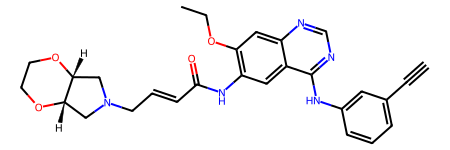

In [21]:
target_mol = Molecule(target_smiles_list[100])
target_mol.rdkit_mol

In [22]:
%%time
# Run retro-star
retro_star_alg.reset()
retro_star_search_graph, _ = retro_star_alg.run_from_mol(target_mol)

CPU times: user 14 s, sys: 83.4 ms, total: 14.1 s
Wall time: 12.6 s


In [23]:
%%time
# Run MCTS
mcts_alg.reset()
mcts_search_graph, _ = mcts_alg.run_from_mol(target_mol)

CPU times: user 14.7 s, sys: 168 ms, total: 14.9 s
Wall time: 13.4 s


In [24]:
# Save graphs
import pickle
for graph, alg_name in [(retro_star_search_graph, "retro star"), (mcts_search_graph, "mcts")]:
    print(f"{alg_name} graph size: {len(graph)}")
    with open(f"search-results-{alg_name}.pkl", "wb") as f:
        pickle.dump(graph, f)

retro star graph size: 17108
mcts graph size: 13380
